In [ ]:

import torch
from torchvision import models
from torchvision import transforms
from PIL import Image

alexnet = models.alexnet(pretrained=True)

In [ ]:
## Standard libraries
import os
import json
import math
import time
import numpy as np
import scipy.linalg

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial10"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

<ipython-input-5-1e6e32f09a96>:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
INFO:lightning_fabric.utilities.seed:Global seed set to 42


Using device cuda:0


In [ ]:
preprocess_image = transforms.Compose([
  transforms.Resize(256),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  transforms.Normalize(
  mean=[0.485, 0.456, 0.406],
  std=[0.229, 0.224, 0.225]
)])


In [ ]:
def fast_gradient_sign_method(model, imgs, labels, epsilon=0.02):
    # Determine prediction of the model
    inp_imgs = imgs.clone().requires_grad_()
    preds = model(inp_imgs.to(device))
    preds = F.log_softmax(preds, dim=-1)
    # Calculate loss by NLL
    loss = -torch.gather(preds, 1, labels.to(device).unsqueeze(dim=-1))
    loss.sum().backward()
    # Update image to adversarial example as written above
    noise_grad = torch.sign(inp_imgs.grad.to(imgs.device))
    fake_imgs = imgs + epsilon * noise_grad
    fake_imgs.detach_()
    return fake_imgs, noise_grad

In [ ]:

# print(prediction_tensor.shape)

In [ ]:
with open('./imagenet_classes.txt') as f:
  labels = [line.strip() for line in f.readlines()]

In [ ]:
def identify_image(image):
  image_tensor = preprocess_image(image)
  input_tensor = torch.unsqueeze(image_tensor, 0)

  alexnet.eval()

  prediction_tensor = alexnet(input_tensor)

  max_value, index_of_max_value = torch.max(prediction_tensor, 1)
  # print(index_of_max_value.numpy())

  predicted_label = labels[index_of_max_value]
  return predicted_label

In [ ]:
!pip install adversarial-robustness-toolbox

In [ ]:
import time
import numpy as np
import torch.nn as nn
from datetime import datetime

from PIL import Image
from torchvision import transforms
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt

from art.estimators.classification import PyTorchClassifier
from skimage.metrics import structural_similarity as ssim

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from art.attacks.evasion import ProjectedGradientDescent
from art.attacks.evasion import FastGradientMethod


In [ ]:
def softmax_activation(inputs):
    inputs = inputs.tolist()
    exp_values = np.exp(inputs - np.max(inputs))

    # Normalize
    probabilities = exp_values / np.sum(exp_values)
    return probabilities



In [ ]:
def compare_images(imageA, imageB):
    return 1 - ssim(imageA, imageB, multichannel=True)

In [ ]:
preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

In [ ]:
criterion = nn.CrossEntropyLoss()

# Create the ART classifier

classifier = PyTorchClassifier(
    model=model_vgg19,
    loss=criterion,
    input_shape=(3, 224, 224),
    nb_classes=1000,
    device_type='gpu'
)

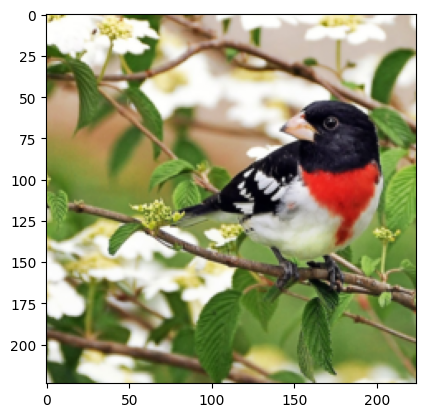

In [ ]:
import requests
# url = "https://raw.githubusercontent.com/fukashi-hatake/kaggle_notebooks/main/images/giant_panda.jpg"
input_image = Image.open('bird1.jpg')

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0).numpy().astype(np.float32)

input = input_batch[0].transpose((1,2,0))
plt.imshow(input)

In [ ]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [ ]:
preds = classifier.predict(input_batch)
print(np.argmax(preds, axis=1))

accuracy = np.max(softmax_activation(preds), axis=1)
accuracy = round(accuracy[0], 2)
print("Accuracy on benign examples: {}%".format(accuracy * 100))

[13]
Accuracy on benign examples: 41.0%


In [ ]:
fgsm_attack = FastGradientMethod(estimator = classifier, eps=0.05)

start = time.time()
x_test_adv = fgsm_attack.generate(x=input_batch)
print("Time for attack (in seconds): {}".format(time.time()-start))

Time for attack (in seconds): 0.07355618476867676


In [ ]:
predictions = classifier.predict(x_test_adv)
print(np.argmax(predictions, axis=1))

accuracy = round(np.max(softmax_activation(predictions), axis=1)[0]*100,2)
print("Accuracy on adversarial test examples: {}%".format(accuracy))

[96]
Accuracy on adversarial test examples: 80.12%


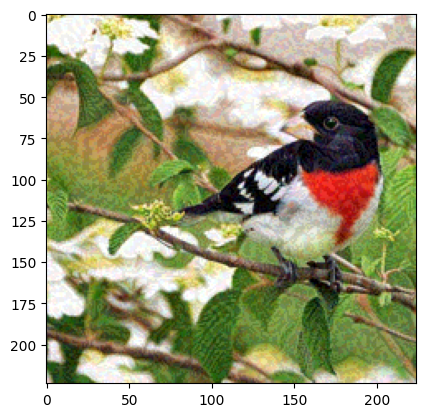

In [ ]:
input = x_test_adv[0].transpose((1,2,0))
plt.imshow(input)

In [ ]:
epsilons = [0, .05, .1, .15, .2, .25, .3]

In [ ]:
original = Image.open('bird1.jpg').convert('RGB')
print(identify_image(original))

16, bulbul


In [ ]:
img1 = Image.open('bird1_fgsm.png').convert('RGB')
print(identify_image(img1))

16, bulbul


In [ ]:
img2 = Image.open('bird1_pgd.png').convert('RGB')
print(identify_image(img2))

16, bulbul
